In [20]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os
os.chdir('/content/drive/MyDrive/100knock-data_analytics/9章') #ここを変更。

In [23]:
# # もしプログラムがエラーになったりした場合、ライブラリのVersionの違いが考えられます。
# # その場合は下記のコメントアウトを外して実行することで、執筆時のVersionがインストールされます。
# # 通常時は実行する必要ありません。
# !pip install -r requirements.txt

# 9章 潜在顧客を把握するための画像認識１０本

ここでは、カメラから取得した映像を用いて画像認識を行い、  
必要な情報を取得するための流れを学ぶことで、  
画像認識をビジネス現場で応用するイメージをつかみます。

### ノック８１：画像データを読み込んでみよう

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("img/img01.jpg")
height, width = img.shape[:2]
print("画像幅: " + str(width))
print("画像高さ: " + str(height))

cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

### ノック８２：映像データを読み込んでみよう

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 情報取得 #
cap = cv2.VideoCapture("mov/mov01.avi")
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print("画像幅: " + str(width))
print("画像高さ: " + str(height))
print("総フレーム数: " + str(count))
print("FPS: " + str(fps))

# 映像のフレーム画像化 #
num = 0
num_frame = 100
list_frame = []
while(cap.isOpened()):
    # 処理（フレームごとに切り出し）
    ret, frame = cap.read()
    # 出力（フレーム画像を書き出し）
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        list_frame.append(frame_rgb)
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break
        if num>num_frame:
          break
    num = num + 1
print("処理を完了しました")
cap.release()

# フレーム画像をアニメーションに変換 #
plt.figure()
patch = plt.imshow(list_frame[0])
plt.axis('off')
def animate(i):
    patch.set_data(list_frame[i])
anim = FuncAnimation(plt.gcf(), animate, frames=len(list_frame), interval=1000/30.0)
plt.close()

# アニメーションを表示 #
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### ノック８３：映像を画像に分割し、保存してみよう

In [ ]:
cap = cv2.VideoCapture("mov/mov01.avi")
num = 0
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        filepath = "snapshot/snapshot_" + str(num) + ".jpg"
        cv2.imwrite(filepath,frame)
    num = num + 1
    if num>=count:
        break
cap.release()
cv2.destroyAllWindows()

### ノック８４：画像内のどこに人がいるのかを検出してみよう

In [ ]:
# 準備 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'groupThreshold':5}

# 検出 #
img = cv2.imread("img/img01.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
human, r = hog.detectMultiScale(gray, **hogParams)
if (len(human)>0):
    for (x, y, w, h) in human:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255,255,255), 3)
cv2_imshow(img)
cv2.imwrite("temp.jpg",img)

Output hidden; open in https://colab.research.google.com to view.

### ノック８５：画像内の人の顔を検出してみよう

In [ ]:
# 準備
cascade_file = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cascade_file)

# 検出
img = cv2.imread("img/img02.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray, minSize=(50, 50))

# 検出した顔に印を付ける
for (x, y, w, h) in face_list:
    color = (0, 0, 225)
    pen_w = 3
    cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness = pen_w)

cv2_imshow(img)
cv2.imwrite("temp.jpg",img)

Output hidden; open in https://colab.research.google.com to view.

### ノック８６：画像内の人がどこに顔を向けているのかを検出してみよう

In [ ]:
import dlib
import math

# 準備 #
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

# 検出 #
img = cv2.imread("img/img02.jpg")
dets = detector(img, 1)

for k, d in enumerate(dets):
    shape = predictor(img, d)

    # 顔領域の表示
    color_f = (0, 0, 225)
    color_l_out = (255, 0, 0)
    color_l_in = (0, 255, 0)
    line_w = 3
    circle_r = 3
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    fontSize = 1
    cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), color_f, line_w)
    cv2.putText(img, str(k), (d.left(), d.top()), fontType, fontSize, color_f, line_w)

    # 重心を導出する箱を用意
    num_of_points_out = 17
    num_of_points_in = shape.num_parts - num_of_points_out
    gx_out = 0
    gy_out = 0
    gx_in = 0
    gy_in = 0
    for shape_point_count in range(shape.num_parts):
        shape_point = shape.part(shape_point_count)
        #print("顔器官No.{} 座標位置: ({},{})".format(shape_point_count, shape_point.x, shape_point.y))
        #器官ごとに描画
        if shape_point_count<num_of_points_out:
            cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_out, line_w)
            gx_out = gx_out + shape_point.x/num_of_points_out
            gy_out = gy_out + shape_point.y/num_of_points_out
        else:
            cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_in, line_w)
            gx_in = gx_in + shape_point.x/num_of_points_in
            gy_in = gy_in + shape_point.y/num_of_points_in

    # 重心位置を描画
    cv2.circle(img,(int(gx_out), int(gy_out)),circle_r,(0,0,255), line_w)
    cv2.circle(img,(int(gx_in), int(gy_in)),circle_r,(0,0,0), line_w)

    # 顔の方位を計算
    theta = math.asin(2*(gx_in-gx_out)/(d.right()-d.left()))
    radian = theta*180/math.pi
    print("顔方位:{} (角度:{}度)".format(theta,radian))

    # 顔方位を表示
    if radian<0:
        textPrefix = "   left "
    else:
        textPrefix = "   right "
    textShow = textPrefix + str(round(abs(radian),1)) + " deg."
    cv2.putText(img, textShow, (d.left(), d.top()), fontType, fontSize, color_f, line_w)

cv2_imshow(img)
cv2.imwrite("temp.jpg",img)

Output hidden; open in https://colab.research.google.com to view.

### ノック８７：検出した情報を統合し、タイムラプスを作ってみよう

In [ ]:
print("タイムラプス生成を開始します")

# 映像取得 #
cap = cv2.VideoCapture("mov/mov01.avi")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'groupThreshold':5}

# タイムラプス作成 #
movie_name = "timelapse.avi"
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
video = cv2.VideoWriter(movie_name,fourcc, 30, (width,height))

num = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)

            video.write(frame)
    else:
        break
    num = num + 1
video.release()
cap.release()
cv2.destroyAllWindows()
print("タイムラプス生成を終了しました")

タイムラプス生成を開始します
タイムラプス生成を終了しました


### ノック８８：全体像をグラフにして可視化してみよう

In [ ]:
import pandas as pd

print("分析を開始します")
# 映像取得 #
cap = cv2.VideoCapture("mov/mov01.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'groupThreshold':5}

num = 0
list_df = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
            list_df = pd.concat([list_df, tmp_se.to_frame().T], ignore_index=True)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
    num = num + 1
cap.release()
cv2.destroyAllWindows()
print("分析を終了しました")

分析を開始します


/tmp/ipython-input-1701295527.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  list_df = pd.concat([list_df, tmp_se.to_frame().T], ignore_index=True)


分析を終了しました


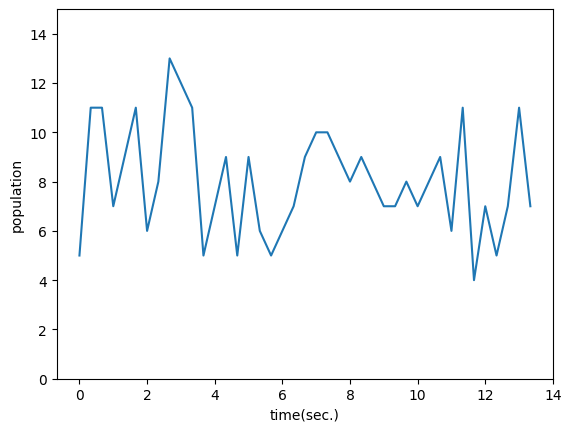

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_df["time"], list_df["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

### ノック８９：人通りの変化をグラフで確認しよう

In [ ]:
print("分析を開始します")
# 映像取得 #
cap = cv2.VideoCapture("mov/mov02.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'groupThreshold':5}

num = 0
list_df2 = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (num%10==0):
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if (len(human)>0):
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
            list_df2 = pd.concat([list_df2, tmp_se.to_frame().T], ignore_index=True)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
    num = num + 1
cap.release()
cv2.destroyAllWindows()
print("分析を終了しました")

分析を開始します


/tmp/ipython-input-1520921738.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  list_df2 = pd.concat([list_df2, tmp_se.to_frame().T], ignore_index=True)


分析を終了しました


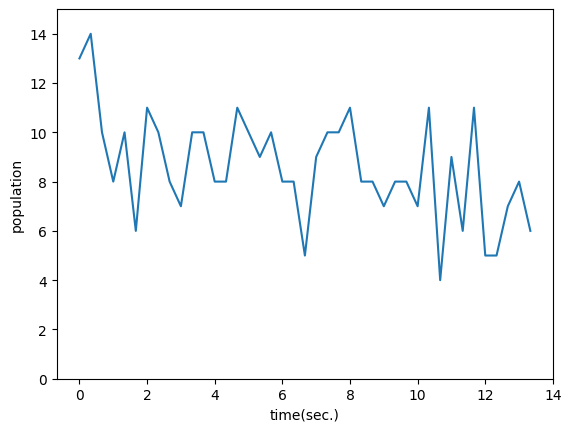

In [ ]:
plt.plot(list_df2["time"], list_df2["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

### ノック９０：移動平均を計算することでノイズの影響を除去しよう

In [ ]:
import numpy as np
def moving_average(x, y):
    y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
    x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
    return x_dat, y_conv

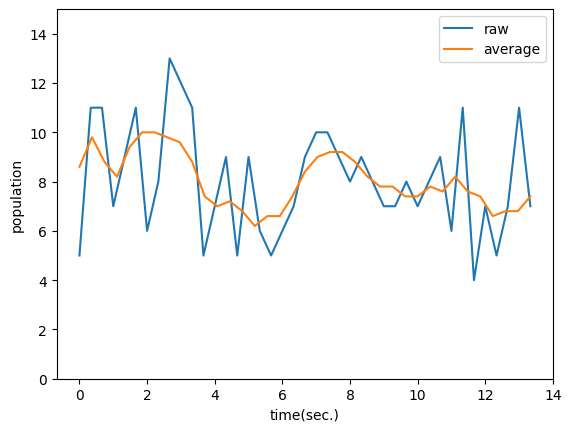

In [ ]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

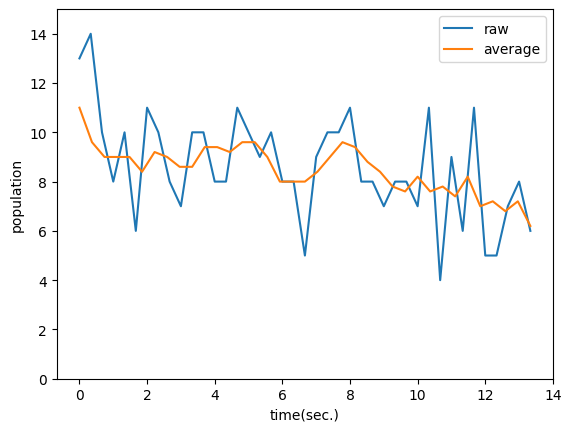

In [ ]:
plt.plot(list_df2["time"], list_df2["people"], label="raw")
ma_x2, ma_y2 = moving_average(list_df2["time"], list_df2["people"])
plt.plot(ma_x2,ma_y2, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

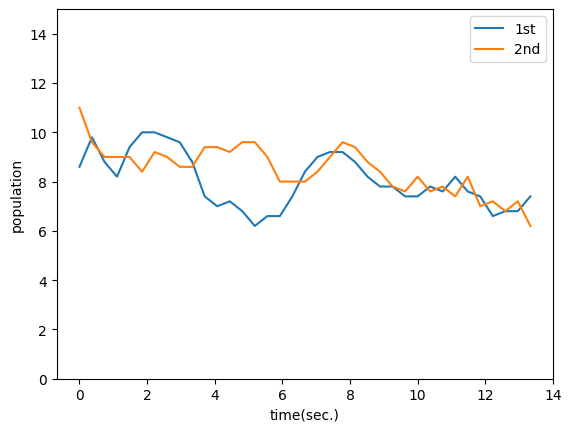

In [ ]:
plt.plot(ma_x,ma_y, label="1st")
plt.plot(ma_x2,ma_y2, label="2nd")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()